In [2]:
### importing packages
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import os
import time

In [3]:
### setting params

# find Dropbox parent directory
cwd = os.getcwd().split('/')
HOME = cwd[1:cwd.index('Dropbox')]
HOME = "/"+"/".join(HOME)

# setting colormap to match Planck's
import sys
sys.path.append(HOME+'/Dropbox/Doutorado/Research/CODES/My-Own-Python-Tools')
import planck_colormap
cm = planck_colormap.colormap()

In [58]:
class ConstrainedRealizations:
    def __init__(self,nside,lmax_factor=1.5,mask=None):
        """Constrained Realizations has to be initialized with parameters and the desired
        mask."""
        self.params = Parameters(nside,lmax_factor)
        if mask is not None:
            self.mask = Mask(mask,nside)
        else:
            self.mask = Mask(np.ones(self.params.npix))
    
    def set_noise_cov(self,noise_cov):
        """Set noise covariance matrix and calculate quantities for messenger loop."""
        self.check_nside(noise_cov)
        self.noise_cov = NoiseCov(noise_cov,self.mask.mask)
        
    def set_signal_cov(self,cl):
        """Set signal cov from Cls and assignt quantities to .signal_cov atribute"""
        self.signal_cov = SignalCov(cl,self.params.lmax)
    ### helper functions    
    def check_nside(self,m):
        assert hp.get_nside(m) == self.params.nside, \
        "Wrong resolution, NSIDE should be {}.".format(self.params.nside)

class Parameters:
    def __init__(self,nside,lmax_factor):
        """Set base parameters"""
        self.nside = nside
        self.npix = hp.nside2npix(nside)
        self.lmax = np.int0(lmax_factor*nside)
        self.pix_area = hp.pixelfunc.nside2pixarea(nside)
        
class Mask:
    """Instantiate mask, get good_pix and bad_pix and degrade with 0.9 criteria if nside_out
is specified."""
    def __init__(self,mask,nside_out=None):
        msk = np.copy(mask)
        if nside_out is not None:
            msk = hp.ud_grade(msk,nside_out)
            msk[msk >= 0.9] = 1
            msk[msk < 0.9] = 0
        self.good_pix = msk == 1
        self.bad_pix = msk == 0
        self.mask = msk
        
class NoiseCov:
    """Noise covariance from map and mask, assigns tau as an attribute"""
    def __init__(self,noise_cov,mask):
        self.tau = np.min(noise_cov[mask==1])
        self.t_cov = self.tau*np.ones(hp.get_map_size(noise_cov))
        self.noise_cov = noise_cov
        
class SignalCov:
    """ Set signal Cls and calculate Sl from Cls and lmax """
    def __init__(self,cl,lmax):
        self.cl = cl[:lmax+1]
        self.cl_inv = np.zeros(lmax+1)
        self.cl_inv[2:] = 1/self.cl[2:]
        l_list, m_list = hp.sphtfunc.Alm.getlm(lmax)
        self.signal_cov = cl[l_list]
        self.signal_cov_inv = np.zeros(len(l_list))
        self.signal_cov_inv[l_list > 1] = 1/self.signal_cov[l_list>1]
        
class CoolingSchedule:
    def __init__(self,lamb_0,eta):
        self.set_lambda_schedule(lamb_0,eta)
    
    def set_lambda_schedule(self,lamb_0,eta):
        """
        Get whole lambda list by multiplying lamb_0 by powers of eta.
        """
        self.lamb_0 = lamb_0
        self.eta = eta
        self.lamb_list = np.array([])
        
        #constructing list
        lamb = lamb_0
        while lamb > 1:
            self.lamb_list = np.append(self.lamb_list,lamb)
            lamb *= eta
        self.lamb_list = np.append(self.lamb_list,1)
    
    def set_precision_schedule(self,target_precision):
        """
        Function to vary target precision as lambda changes.
        Split eps in three parts by factors of 10.
        """
        self.tp = target_precision
        self.eps_list = 10**(2) * target_precision * np.ones(len(self.lamb_list))
        self.eps_list[len(self.lamb_list)//3:] = 10**1 * target_precision
        self.eps_list[2*len(self.lamb_list)//3:] =  target_precision
        


In [78]:
## schematic for delta class
class Delta:
    def __init__(self,noise_cov,cl_inv,mask,pix_area):
        self.sqrt_ncov_inv = 1/np.sqrt(noise_cov[mask==1])
        self.cl_g2s = (pix_area**2)*cl_inv
    
    def gen_delta(self,mask):
        g1n = self.sqrt_ncov_inv*np.random.normal(size=len(self.sqrt_ncov_inv))
        g2s = hp.synfast(self.cl_g2s,hp.get_nside(mask),len(self.cl_g2s)-1, verbose=False)
        delta = np.zeros(hp.get_map_size(mask))
        delta[mask == 1] = g1n + g2s[mask==1]
        delta[mask == 0] = g2s[mask == 0]
        return delta

In [79]:
### set-up for testing
nside = 32
npix = hp.nside2npix(nside)
mask = np.zeros(npix)
mask[len(mask)//2:] = 1
ncov = np.arange(npix)
c_l = np.random.normal(loc=30,scale=10,size=1000)
## initialize
cr1 = ConstrainedRealizations(32,mask=mask)
## get params
print(cr1.params.pix_area)
## get mask stuff
print(cr1.mask.good_pix)
# set noise_cov
cr1.set_noise_cov(ncov)
# get tau
print(cr1.noise_cov.tau)
# set signal cov
cr1.set_signal_cov(c_l)
# get sl
cr1.signal_cov.signal_cov
print(cr1.signal_cov.cl_inv)

0.0010226538585904274
[False False False ...,  True  True  True]
6144
[ 0.          0.          0.03509748  0.02662111  0.04197662  0.02729811
  0.03146608  0.04673378  0.02425737  0.0385627   0.03650676  0.02266308
  0.04359917  0.0382622   0.03110967  0.03750511  0.03313212  0.03520271
  0.05830017  0.03966663  0.03257876  0.08866068  0.10033076  0.04909516
  0.0286938   0.03106578  0.03989868  0.02824012  0.02431057  0.02698757
  0.08811927  0.06179719  0.03638893  0.04393957  0.01865099  0.03437006
  0.03357875  0.04261404  0.02383676  0.03718701  0.04813891  0.02687385
  0.0272632   0.0406343   0.04032827  0.02969183  0.02326048  0.03317373
  0.02718646]


In [80]:
delta = Delta(cr1.noise_cov.noise_cov,cr1.signal_cov.cl_inv,cr1.mask.mask,cr1.params.pix_area)

/home/marcio/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


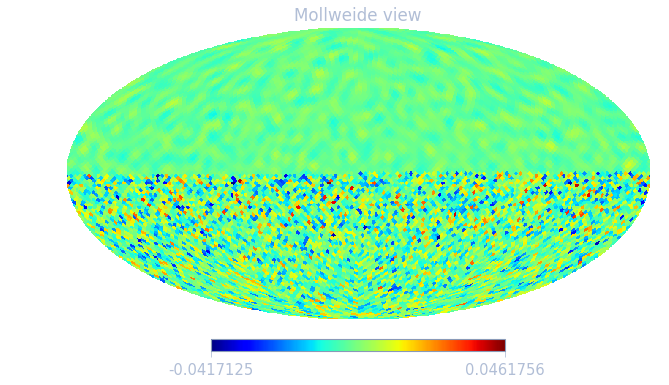

In [82]:
hp.mollview(delta.gen_delta(cr1.mask.mask))